### May 18, 2025

This notebook is from Prince+Dunkly 2022, https://journals.aps.org/prd/abstract/10.1103/PhysRevD.105.023518. The arXiv version is not up-to-date.

I can run the notebook in full. To do that, I created a kernel "Cobaya", using a conda environment. The conda environment has to be created in $PSCRATCH (gpt says my home directory would work too), but not in the project directory: /global/cfs/projectdirs/cosmo/work/users/xhuang/xh-repos

`conda create -n cobaya-scratch python=3.10`

I then followed gpt instructions:

`conda install ipykernel`
 
`python -m ipykernel install --user --name cobaya-scratch --display-name "Cobaya"`

I then installed cobaya (https://cobaya.readthedocs.io/en/latest/installation.html) 

`python -m pip install cobaya --upgrade`

and then (https://cobaya.readthedocs.io/en/latest/installation_cosmo.html)

`cobaya-install cosmo -p /pscratch/sd/x/xshuang/cobaya-cosmo-scratch`

In installing the Cobaya `cosmo` package, I ran into trouble with Python 3.11. GPT was right: after creating an environment with 3.10 everything worked.

(Previously I created a conda environment (`cobaya-env`) in order to create a kernel in the project directory above, but that didn't work. That's why I created `cobaya-scratch` in $PSCRATCH. `cobaya-env` was then removed.)




# cobaya example
You can run this if you have cobaya installed on your computer (see https://cobaya.readthedocs.io/en/latest/)

You will need to set the cobaya_modules_path variable below to wherever the cobaya cosmological codes and likelihoods are installed on your computer

This plots a slice the low-ell EE likelihood for different values of tau, and the low-ell TT likelihood for different values of n_s.

For more about the model wrapper of cobaya see https://cobaya.readthedocs.io/en/latest/cosmo_model.html

In [1]:
# cobaya_modules_path='/Users/heatherp/cobaya-cosmo'

cobaya_modules_path='/pscratch/sd/x/xshuang/cobaya-cosmo-scratch'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from cobaya.model import get_model
from cobaya.yaml import yaml_load

In [3]:
'''
Notes on the ymal file below:

- Cl # probably just the spherical harmonics coefficients

- requires: {'Cl': {'ee': 29}}  # 29 means l < 30, or the low ell's. For Planck, l < 30 and l >= 30 are treated differently; see Prince thesis.

- planck_2018_highl_plik.TTTEEE_lite: null # I don't understand this line.

- gpt asks me to add this line: 

    output: chains/w0wa_planck_low

   it actually caused an error the second time I ran it.


'''


info_txt = r'''
likelihood:
  planck_low_py_EE: 
      external: import_module('planck_low_py').planck_lowE_binned_loglike_cobaya
      requires: {'Cl': {'ee': 29}}
  planck_low_py_TT: 
      external: import_module('planck_low_py').planck_lowT_binned_loglike_cobaya
      requires: {'Cl': {'tt': 29}}
  planck_2018_highl_plik.TTTEEE_lite: null
params:
  # fixed
  H0: 67
  ombh2: 0.022
  omch2: 0.12
  # sampled
  As:
    prior:
      min: 1e-9
      max: 6e-9
  ns:
    prior:
      min: 0.8
      max: 1.2
  tau:
    prior:
      min: 0.005
      max: 0.8

  w:
    prior:
      min: -2
      max: 0
    ref:
      dist: norm
      loc: -1
      scale: 0.3
    latex: w_0
    
  wa:
    prior:
      min: -2
      max: 2
    ref:
      dist: norm
      loc: 0
      scale: 0.3
    latex: w_a
      
theory:
  camb:
    extra_args:
      dark_energy_model: ppf

sampler:
  mcmc: null
'''

In [4]:
info = yaml_load(info_txt)
info['modules'] = cobaya_modules_path

model = get_model(info)

[model] *WARNING* Ignored blocks/options: ['sampler', 'modules']
[camb] `camb` module loaded successfully from /pscratch/sd/x/xshuang/cobaya-cosmo-scratch/code/CAMB/camb
[planck_low_py_ee] Initialized external likelihood.
[planck_low_py_tt] Initialized external likelihood.
[planck_2018_highl_plik.ttteee_lite] `clik` module loaded successfully from /pscratch/sd/x/xshuang/cobaya-cosmo-scratch/code/planck/clik-main/lib/python/site-packages/clik
 Initializing Planck likelihood, version Plik_v22_cmbonly_like                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               


## Sanity checks

In [5]:
'''
Looks like Prince is checking if she gets sensible likelihood value given a set of parameter values.

But what is A_planck. That was not in the parameter list above. Summary from gpt:

Summary:
A_planck is a nuisance parameter for the overall calibration of Planck CMB power spectra, 
expected to be ~1. It's included to marginalize over calibration uncertainties.

'''

point={'As': 2.1e-9, 'ns': 0.97, 'tau': 0.054, 'A_planck': 1, 'w': -1, 'wa': 0}
logposterior = model.logposterior(point)
print('   loglikelihoods: %r' % dict(zip(list(model.likelihood), logposterior.loglikes)))

   loglikelihoods: {'planck_low_py_EE': np.float64(9.65616509640383), 'planck_low_py_TT': np.float64(-11.660671409109057), 'planck_2018_highl_plik.TTTEEE_lite': np.float64(-304.5157530862834)}


expected: loglikelihoods: {'planck_low_py_EE': 9.657378671445292, 'planck_low_py_TT': -11.661059579231594, 'planck_2018_highl_plik.TTTEEE_lite': -304.7233213973714}

## EE tau slice

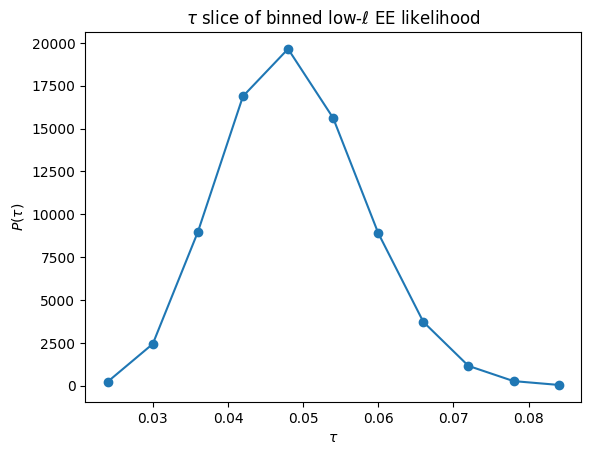

In [6]:
'''
Prince now calculates and plots the likelihoods of an array of tau values, while fixing all other cosmological and nuisance parameters.

If the code passes this test -- if the likelihood peaks at the right tau value -- that it's promising that the sampling will work.

'''


n=11
tau_arr = np.linspace(0.054-0.03, 0.054+0.03, n)
loglike_tau_EE=np.empty_like(tau_arr)
for i, tau in enumerate(tau_arr):
    loglikes=model.loglikes({'tau': tau, 'As': 2.1e-9, 'ns': 0.97, 'A_planck': 1, 'w':-1, 'wa':0})[0]
    loglike_tau_EE[i]=loglikes[0]


plt.plot(tau_arr, np.exp(loglike_tau_EE), marker='o')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$P(\tau)$')
plt.title(r'$\tau$ slice of binned low-$\ell$ EE likelihood')
plt.show()

## TT n_s slice

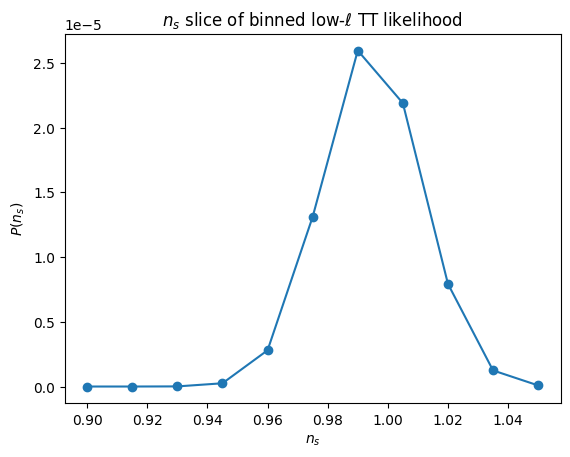

In [7]:
'''
Similar to the cell above: Prince now calculates and plots the likelihoods of an array of n_s values, 
while fixing all other cosmological and nuisance parameters.

If the code passes this test -- if the likelihood peaks at the right n_s value -- that it's promising that the sampling will work.

'''

n=11
ns_arr = np.linspace(0.9, 1.05, n)
loglike_ns_TT=np.empty_like(ns_arr)
for i, ns in enumerate(ns_arr):
    loglikes=model.loglikes({'ns': ns, 'As': 2.1e-9, 'tau': 0.054, 'A_planck': 1, 'w':-1, 'wa':0})[0]
    loglike_ns_TT[i]=loglikes[1]


plt.plot(ns_arr, np.exp(loglike_ns_TT), marker='o')
plt.xlabel(r'$n_s$')
plt.ylabel(r'$P(n_s)$')
plt.title(r'$n_s$ slice of binned low-$\ell$ TT likelihood')
plt.show()

## TT w slice

<function matplotlib.pyplot.show(close=None, block=None)>

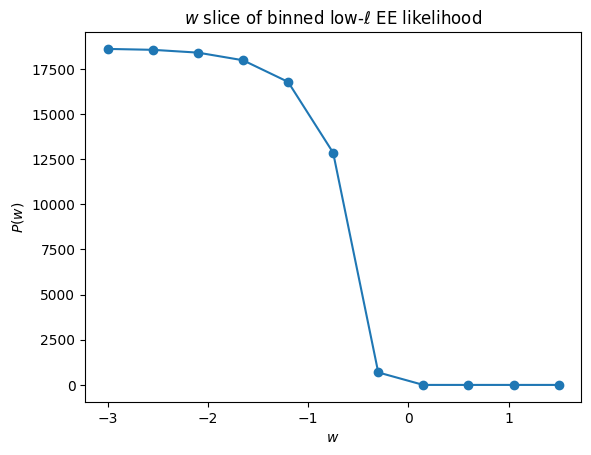

In [8]:

n=11
w_arr = np.linspace(-1-2, 1+0.5, n)
loglike_w_EE=np.empty_like(w_arr)
for i, w in enumerate(w_arr):
    loglikes=model.loglikes({'w': w, 'As': 2.1e-9, 'ns': 0.97, 'A_planck': 1, 'wa': 0, 'tau':0.054})[0]
    loglike_w_EE[i]=loglikes[0]

plt.plot(w_arr, np.exp(loglike_w_EE), marker='o')
plt.xlabel(r'$w$')
plt.ylabel(r'$P(w)$')
plt.title(r'$w$ slice of binned low-$\ell$ EE likelihood')
plt.show

## EE wa slice

<function matplotlib.pyplot.show(close=None, block=None)>

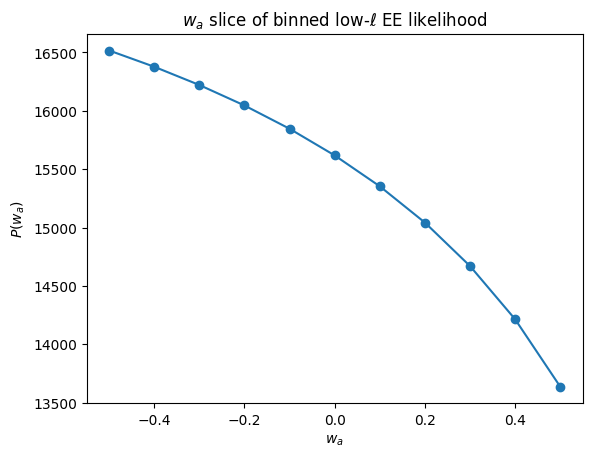

In [9]:
n=11
wa_arr = np.linspace(-0.5, 0.5, n)
loglike_wa_EE=np.empty_like(wa_arr)
for i, wa in enumerate(wa_arr):
    loglikes=model.loglikes({'wa': wa, 'As': 2.1e-9, 'ns': 0.97, 'A_planck': 1, 'w': -1, 'tau':0.054})[0]
    loglike_wa_EE[i]=loglikes[0]

plt.plot(wa_arr, np.exp(loglike_wa_EE), marker='o')
plt.xlabel(r'$w_a$')
plt.ylabel(r'$P(w_a)$')
plt.title(r'$w_a$ slice of binned low-$\ell$ EE likelihood')
plt.show

In [10]:
from cobaya.run import run

# Set the output path for chains (adjust as needed)
# output_path = "/global/cfs/projectdirs/cosmo/work/users/xhuang/xh-repos/planck-low-py/output"

output_path = "/global/cfs/projectdirs/cosmo/work/users/xhuang/xh-repos/planck-low-py/output_w0wa_test1"


# Add to your info dict:
info["output"] = output_path

# Run Cobaya
# info["sampler"] = {"mcmc": None}
updated_info, sampler = run(info)


[output] Output to be read-from/written-into folder '/global/cfs/projectdirs/cosmo/work/users/xhuang/xh-repos/planck-low-py', with prefix 'output_w0wa_test1'
[output] *ERROR* File /global/cfs/projectdirs/cosmo/work/users/xhuang/xh-repos/planck-low-py/output_w0wa_test1.input.yaml.locked is locked by another process, you are running with MPI disabled but may have more than one process. Make sure that you have mpi4py installed and working.Note that --test should not be used with MPI.


LoggedError: File /global/cfs/projectdirs/cosmo/work/users/xhuang/xh-repos/planck-low-py/output_w0wa_test1.input.yaml.locked is locked by another process, you are running with MPI disabled but may have more than one process. Make sure that you have mpi4py installed and working.Note that --test should not be used with MPI.

In [ ]:
# from getdist import plots
# from getdist.mcsamples import loadMCSamples

# # Adjust path to your Cobaya output
# samples = loadMCSamples('/global/cfs/projectdirs/cosmo/work/users/xhuang/xh-repos/planck-low-py/output')

# # For parameter names, check samples.getParamNames().names
# g = plots.get_subplot_plotter()
# g.triangle_plot(samples, ['w', 'wa', 'omegam'], filled=True)
